<a id='section1'></a>
## Importing data & libraries

In [1]:
agb_data_path = "preprocess/agb_avitabile_2010-2016_v3.nc" #Baseline data

In [2]:
spi_gpcc_data_path = "raw/SPI_GPCC"

In [3]:
import xarray as xr
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt

In [4]:
"""Load AGB data into an xarray dataset"""
agb_data = xr.open_dataset(agb_data_path)

### Loading and Combining all the files present in SPI GPCC folder

In [5]:
#Function to get all file names
def _get_file_list(root):
    files = [join(root, f) for f in listdir(root) if isfile(join(root, f)) and f.endswith(".nc")]
    dirs = [d for d in listdir(root) if isdir(join(root, d))]
    return files
list_files = sorted(_get_file_list(spi_gpcc_data_path))  #List of data file paths
spi_gpcc_data = xr.open_mfdataset(paths=list_files, parallel=True)

## Before Pre-Processing

In [6]:
print(spi_gpcc_data)

<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 1200, time: 95)
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 0.0 0.3 0.6 0.9 ... 358.8 359.1 359.4 359.7
  * time       (time) datetime64[ns] 2010-01-01 2010-02-02 ... 2017-11-11
Data variables:
    spi03      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi06      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi12      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-24T08:59:39

In [7]:
#Pandas describe method
print(spi_gpcc_data.to_dataframe().describe())

              spi03         spi06         spi12
count  1.912102e+07  1.972782e+07  1.991714e+07
mean   6.889641e-02  8.268022e-02  9.939095e-02
std    9.915277e-01  1.006299e+00  1.018818e+00
min   -3.090235e+00 -3.090235e+00 -3.090235e+00
25%   -5.898249e-01 -5.902328e-01 -5.765619e-01
50%    6.601524e-02  8.359432e-02  1.031246e-01
75%    7.261734e-01  7.515631e-01  7.769527e-01
max    3.090357e+00  3.090341e+00  3.090236e+00


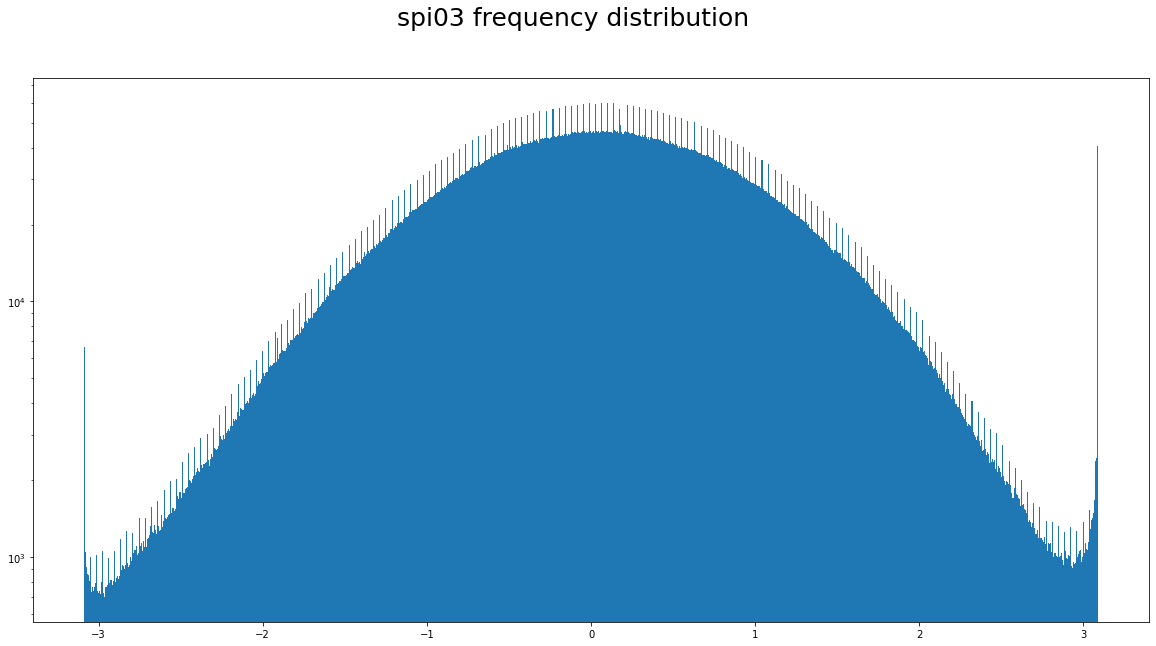

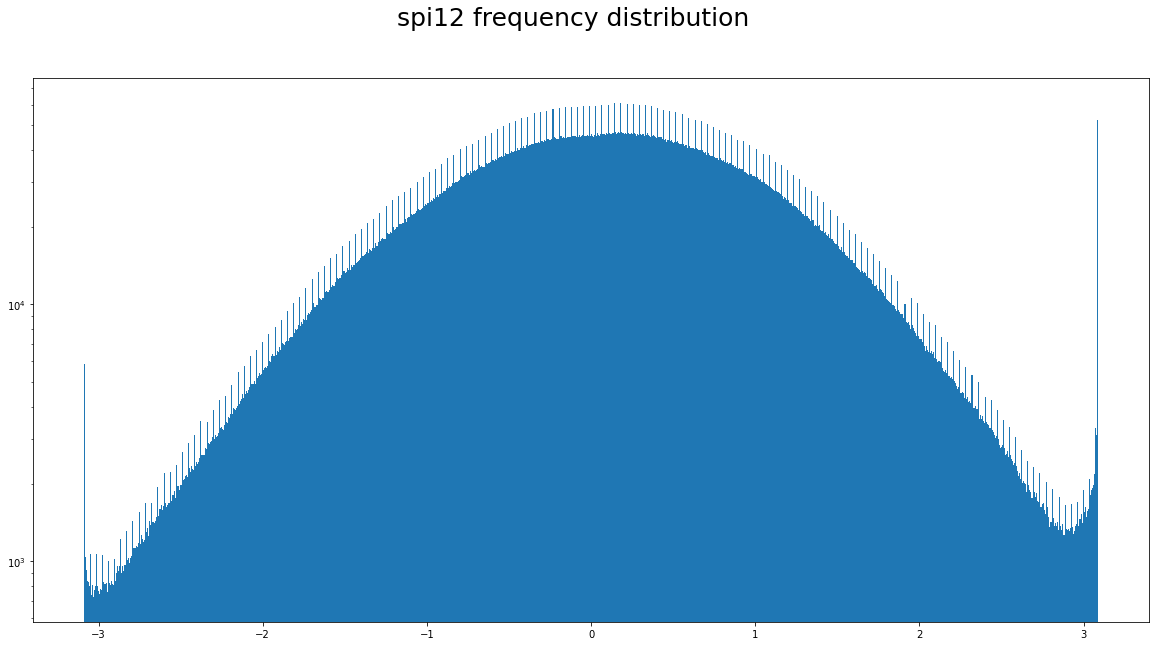

In [8]:
var_list =['spi03', 'spi12']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(spi_gpcc_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

<a id='section2'></a>
## Pre-processing of Slopes

### Droping features that are not required

In [9]:
spi_gpcc_data = spi_gpcc_data.drop(["spi06"])

### Slicing dataset to take data between years 2010-2016

In [10]:
spi_gpcc_data = spi_gpcc_data.sel(time=slice(spi_gpcc_data.time.values[0], spi_gpcc_data.time.values[83]))

### Interpolating dataset to match resolution of AGB dataset

In [11]:
spi_gpcc_data = spi_gpcc_data.assign_coords({'latitude':spi_gpcc_data.latitude.values,'longitude':xr.where(spi_gpcc_data.longitude > 180, spi_gpcc_data.longitude - 360, spi_gpcc_data.longitude) })

In [12]:
spi_gpcc_data = spi_gpcc_data.interp({'latitude':agb_data.latitude.values,'longitude':agb_data.longitude.values})

### Correcting time values

In [13]:
spi_gpcc_data = spi_gpcc_data.drop("time")
spi_gpcc_data = spi_gpcc_data.assign_coords({"time": agb_data.time.values})

### Dataset after pre-processing

In [14]:
print(spi_gpcc_data)

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
Data variables:
    spi03      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    spi12      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-24T08:59:39 GRIB to CDM+CF via cfgrib-0....


In [15]:
#Pandas describe method
print(spi_gpcc_data.to_dataframe().describe())

              spi03         spi12
count  2.343786e+07  2.449869e+07
mean   6.338775e-02  9.042699e-02
std    9.900747e-01  1.013486e+00
min   -3.090235e+00 -3.090235e+00
25%   -5.942154e-01 -5.845146e-01
50%    5.938371e-02  8.896542e-02
75%    7.208004e-01  7.652747e-01
max    3.090357e+00  3.090236e+00


### Plots

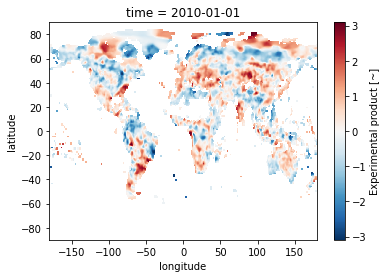

In [16]:
spi_gpcc_data.spi03[0].plot()

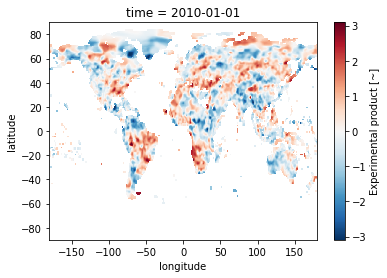

In [17]:
spi_gpcc_data.spi12[0].plot()

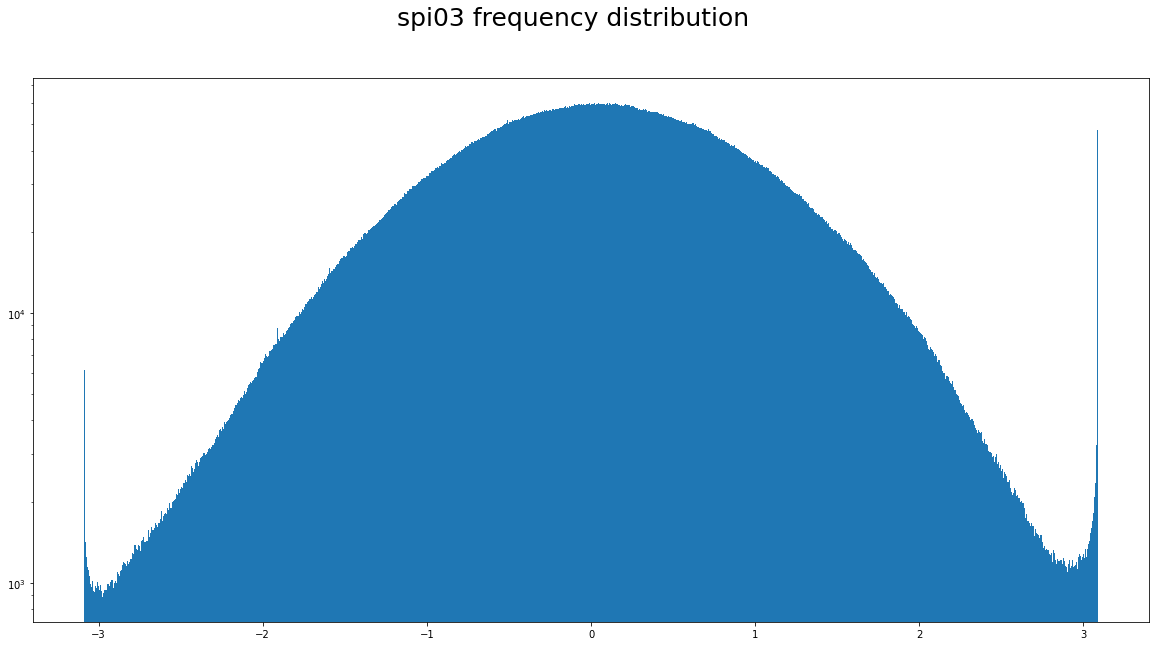

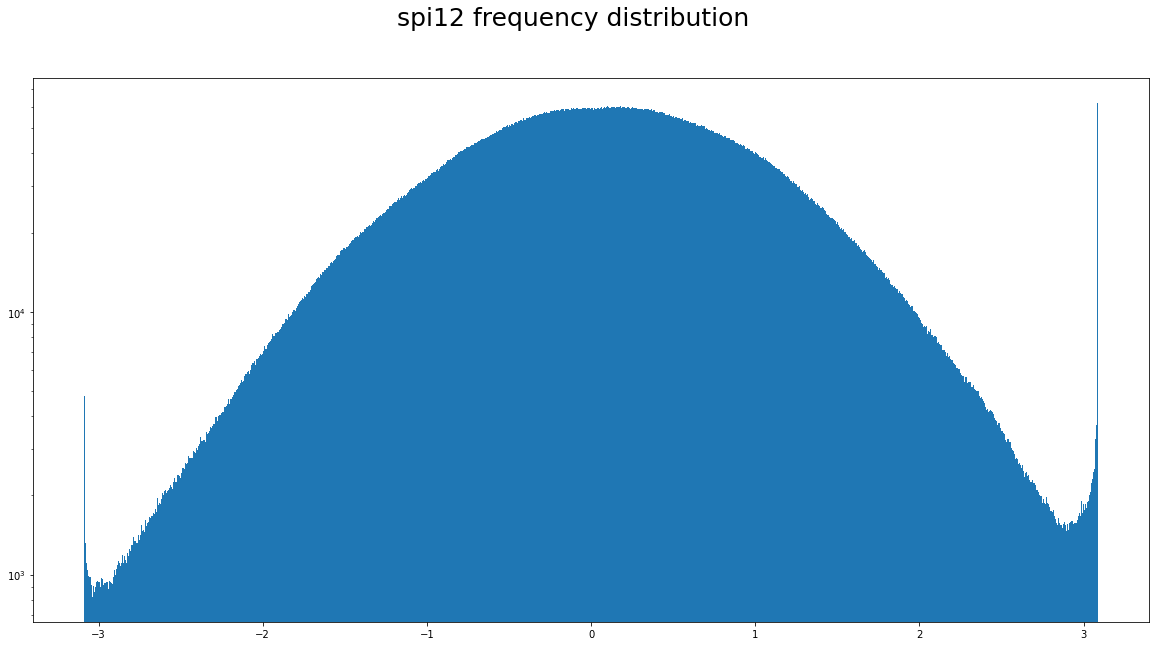

In [18]:
var_list =['spi03', 'spi12']
for i in range(len(var_list)):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} frequency distribution', fontsize=25)
    plt.hist(spi_gpcc_data[var_list[i]].values.flatten(), bins=1000, cumulative=False, log=True)

### Saving pre-processed file

In [19]:
spi_gpcc_data.to_netcdf("preprocess/spi-gpcc_2010-2016_corrected_v3.nc")

In [20]:
#File size
print(os.stat("preprocess/spi-gpcc_2010-2016_corrected_v3.nc").st_size/1e9,"GB")

0.696758289 GB
